# Chapter 4: Minimum spanning trees

In this chapter we will continue to study algorithms that process graphs. We will implement Kruskal's algorithm to construct the **minimum spanning tree** of a graph, a subgraph that efficiently connects all nodes.

## Trees in python

A tree is an undirected graph where any two edges are connected by **exactly one path**. For example, consider the tree below.

![A simple tree](Figures/example_tree.png)

We can represent in python using dictionaries, as we did in the last chapter.

In [1]:
tree_dict = {'A' : set(['D']), 'B' : set(['D']), 'C' : set(['D']),
             'D' : set(['A', 'B', 'C', 'E']), 'E' : set(['D', 'F']), 'F' : set(['E'])}

Though in this chapter, we prefer to represent the tree as a list (set) of links:

In [2]:
tree_links = [(node, neighbor) for node in tree_dict.keys() for neighbor in tree_dict[node]]
tree_links

[('A', 'D'),
 ('E', 'F'),
 ('E', 'D'),
 ('D', 'C'),
 ('D', 'A'),
 ('D', 'B'),
 ('D', 'E'),
 ('C', 'D'),
 ('B', 'D'),
 ('F', 'E')]

If we choose one node as the **root** of the tree, we have exactly one path from this root to each of the other terminal nodes. This idea can applied recursively as follows: from this root, each neighboring is itself a root of a subtree. Each of these subtrees also consist of a root and possibly one or more subtrees. Hence we can also represent the tree as a nested sublist:

```
tree = [root, [subtree1], [subtree2],...]
```

For our example, we obtain when taking node D as a root: (see [here](http://interactivepython.org/courselib/static/pythonds/Trees/ListofListsRepresentation.html))

In [3]:
tree_list = ['D', ['A'], ['B'], ['C'], ['E', ['F']]]

## Minimum spanning tree

Suppose we have an undirected connected weighted graph $G$ as depicted below.

![A weighted graph](Figures/graph.png)

Weighted graphs can either be implemented as a set of weighted edges of as a dictionary.

In [4]:
vertices = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

edges = set([(5, 'A', 'D'), (7, 'A', 'B'), (8, 'B', 'C'), (9, 'B', 'D'),
         (7, 'B', 'E'), (5, 'C', 'E'), (15, 'D', 'E'), (6, 'F', 'D'), 
        (8, 'F', 'E'), (9, 'E', 'G'), (11, 'F', 'G')])

In [5]:
weighted_adj_list = {v : set([]) for v in vertices}

for weight, vertex1, vertex2 in edges:
    weighted_adj_list[vertex1].add((weight, vertex2))
    weighted_adj_list[vertex2].add((weight, vertex1))  # undirected graph, in=outgoing edge

weighted_adj_list

{'A': {(5, 'D'), (7, 'B')},
 'B': {(7, 'A'), (7, 'E'), (8, 'C'), (9, 'D')},
 'C': {(5, 'E'), (8, 'B')},
 'D': {(5, 'A'), (6, 'F'), (9, 'B'), (15, 'E')},
 'E': {(5, 'C'), (7, 'B'), (8, 'F'), (9, 'G'), (15, 'D')},
 'F': {(6, 'D'), (8, 'E'), (11, 'G')},
 'G': {(9, 'E'), (11, 'F')}}

For example, the nodes may represent cities and the weight of an edge may represent the cost of implementing a communication line between two cities. If we want to make communication possible between all cities, these should be a path between any two cities. A **spanning tree** is a subgraph of $G$ that is a tree which contains all nodes of $G$. The cost of the spanning tree is simply the sum of a the weights of the edges in this tree. Often, multiple spanning trees can be chosen from a connected graph. The **minimum spanning tree** is simply the spanning tree with the lowest cost.

The figure below shows the minimum spanning tree for $G$ in green.

![A weighted graph](Figures/min_spanning_tree.png)

Minimum spanning trees have many applications:
- design of computer-, telecommunication-, transportation- and other networks
- hierachical clustering
- image segmentation and feature extraction
- phylogenetic analysis
- construction of mazes

## Disjoint-set data structure

Implementing an algorithm for finding the minimum spanning tree is fairly straightforward. The only bottleneck is that the algorithm requires the a **disjoint-set data structure** to keep track of a set partitioned in a number of disjoined subsets.

For example, consider the following inital set of eight elements.

![A set of eight elements](Figures/disjointset1.png)

We decide to group elements A, B and C together in a subset and F and G in another subset.

![The same set, but after grouping some elements together.](Figures/disjointset2.png)

The disjoint-set data structure support the following operations:
- **Find** check which subset an element is in. Is typically used to check whether two objects are in the same subset.
- **Union** to merge two subsets into a single subset.

A python implementation of a disjoint-set is available using an union-set forest. A simple example will make everything clear!

In [6]:
from union_set_forest import USF

animals = ['mouse', 'bat', 'robin', 'trout', 'seagull', 'hummingbird',
           'salmon', 'goldfish', 'hippopotamus', 'whale', 'sparrow']
union_set_forest = USF(animals)

# group mammals together
union_set_forest.union('mouse', 'bat')
union_set_forest.union('mouse', 'hippopotamus')
union_set_forest.union('whale', 'bat')

# group birds together
union_set_forest.union('robin', 'seagull')
union_set_forest.union('seagull', 'sparrow')
union_set_forest.union('seagull', 'hummingbird')
union_set_forest.union('robin', 'hummingbird')

# group fishes together
union_set_forest.union('goldfish', 'salmon')
union_set_forest.union('trout', 'salmon')

In [7]:
# mouse and whale in same subset?
print(union_set_forest.find('mouse') == union_set_forest.find('whale'))

True


In [8]:
# robin and salmon in the same subset?
print(union_set_forest.find('robin') == union_set_forest.find('salmon'))

False


## Kruskal's algorithm

Kruskal's algorithm is a very simple algorithm to find the minimum spanning tree. The main idea is to start with an intial 'forest' of the induvidual nodes of the graph. In each step of the algorithm we add an edge with the smallest possible value that connects two disjoints trees in the forest. This process is continued until we have a single tree, which is a minimum spanning tree, or until all edges are considered. In the former case the algoritm returns the minimum spanning forest. 

### Example run of Kruskal's algorithm

Consider the weighted graph again.

![A weighted graph](Figures/graph.png)

In a first step, the algorithm selects the edge with the lowest weight, here connecting nodes A and D. This edge has a weight of 5.

![The first edge with lowest weight is selected.](Figures/K1.png)



The next edge that is selected connects nodes C and E. This edge also has a weight of 5.

![The second edge is selected.](Figures/K2.png)

The edge between D and F is subsequently selected.

![A third edge is added to the forest.](Figures/K3.png)



In the current forest, the edge between B and D becomes inaccessible. Taking this edge would result in a cycle in our graph (B and D are already connected through A in our forest), so it is forbidden.

![Now edge BD becomes forbidden, because adding it to our forest would result in a cycle.](Figures/K4.png)


The next allowd edge with the lowest weight is between nodes B and E. Taking this edges connects two independent components in our forest and makes other edges forbidden.

![We add edge BD, connecting two components in our forest.](Figures/K5.png)


Finally, edge EG connects the last node G to our tree with the lowest cost.

![Adding edge EG results in the minimum spanning tree.](Figures/K6.png)

### Pseudocode of Kruskal's algorithm

```
function Kruskal(G):
1 A := empty list
2 for each node v in G
3    MAKE-SET(v)
4 for each edge (u, v) ordered by weight(u, v), increasing:
5    if FIND-SET(u) ≠ FIND-SET(v):
6       add (u, v) to A
7       UNION(u, v)
8 return A
```

### Time complexity of Kruskal's algorithm

We assume that by using a disjoint set data structure, ```FIND``` and ```UNION``` can be performed using a time complexity of $\mathcal{O}(1)$. Then the only cost is in sorting the edges by their weight, which can be done with a time complexity of $\mathcal{O}(|E| \log(|E|))$, which is the time complexity of generating the minimum spanning tree using this algorithm.

**Assignment 1: completing Kruskal's algorithm**

1. Complete the code for Kruskals algorithm below. Test the code on the example network given above.
2. Ticket to Ride is a fun boardgame in which you have to connect trains to several important cities in the United States. Load the vertices (cities) and edges (roads) from the file `ticket_to_ride.py`. Compute a minimum spanning tree.

![The map of Ticket to Ride.](Figures/TtRmap.jpg)

In [9]:
def kruskal(vertices, edges):
    """
    Kruskal's algorithm for finding a minimum spanning tree
    Input :
        - vertices : a set of the vertices of the graph
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B')) for an
                    edge from node A to node B with weigth 0.7
    Output:
        a minumum spanning tree represented as a list of edges
    """
    A = []
    cost = 0
    
    forest_set = USF(vertices)
    for edge in sorted(edges):
        if forest_set.find(edge[1]) != forest_set.find(edge[2]):
            A.append((edge[1], edge[2]))
            forest_set.union(edge[1], edge[2])
            cost += edge[0]
        
    return A, cost

In [10]:
vertices = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
edges = [(5, 'A', 'D'), (7, 'A', 'B'), (8, 'B', 'C'), (9, 'B', 'D'),
         (7, 'B', 'E'), (5, 'C', 'E'), (15, 'D', 'E'), (6, 'F', 'D'), 
        (8, 'F', 'E'), (9, 'E', 'G'), (11, 'F', 'G')]

print(kruskal(vertices, edges))

([('A', 'D'), ('C', 'E'), ('F', 'D'), ('A', 'B'), ('B', 'E'), ('E', 'G')], 39)


In [11]:
from ticket_to_ride import vertices as cities
from ticket_to_ride import edges as roads

In [12]:
for city in cities:
    print(city)

Atlanta
Boston
Calgary
Charleston
Chicago
Dallas
Denver
Duluth
El Paso
Helena
Houston
Kansas City
Las Vegas
Little Rock
Los Angeles
Miami
Montreal
Nashville
New Orleans
New York
Oklahoma City
Omaha
Phoenix
Pittsburgh
Portland
Raleigh
Saint Louis
Salt Lake City
San Francisco
Santa Fe
Sault St. Marie
Seattle
Toronto
Vancouver
Washington DC
Winnipeg


In [13]:
# compute here the MST for Ticket to Ride
kruskal(cities, roads)

([('Atlanta', 'Nashville'),
  ('Charleston', 'Raleigh'),
  ('Dallas', 'Houston'),
  ('Kansas City', 'Omaha'),
  ('Portland', 'Seattle'),
  ('Seattle', 'Vancouver'),
  ('Atlanta', 'Charleston'),
  ('Boston', 'Montreal'),
  ('Boston', 'New York'),
  ('Chicago', 'Saint Louis'),
  ('Dallas', 'Little Rock'),
  ('Dallas', 'Oklahoma City'),
  ('Denver', 'Santa Fe'),
  ('Duluth', 'Omaha'),
  ('El Paso', 'Santa Fe'),
  ('Houston', 'New Orleans'),
  ('Kansas City', 'Oklahoma City'),
  ('Kansas City', 'Saint Louis'),
  ('Las Vegas', 'Los Angeles'),
  ('Los Angeles', 'Phoenix'),
  ('Nashville', 'Saint Louis'),
  ('New York', 'Pittsburgh'),
  ('New York', 'Washington DC'),
  ('Raleigh', 'Washington DC'),
  ('Sault St. Marie', 'Toronto'),
  ('Calgary', 'Vancouver'),
  ('Denver', 'Salt Lake City'),
  ('Duluth', 'Sault St. Marie'),
  ('El Paso', 'Phoenix'),
  ('Los Angeles', 'San Francisco'),
  ('Calgary', 'Helena'),
  ('Charleston', 'Miami'),
  ('Dallas', 'El Paso'),
  ('Denver', 'Helena'),
  ('Dulut

## The travelling salesman problem

The traveling salesman problem is a well-known problem in computer science. The goal is to find a tour in a graph with a minimal cost. This problem is NP-hard, there is no algorithm to solve this efficiently for large graphs.

The tour is represented as a dictionary, for each key-value pair a vertex and the associated next vertex in the tour.

Below are two heuristic algorithms to find a good tour.

### Nearest Neighbour

The simplest algorithm, can be done in with a time complexity of $\mathcal{O}(|V|^2)$.

1. Select a random vertex.
2. Find the nearest univisited vertex and add it to the path.
3. Are there any unvisited vertices left? If yes, repeat step 2.
4. Return to the first vertex.

### Greedy

A greedy algorithm that gives a solution in $\mathcal{O}(|V|^2\log(|V|))$ time.

1. Sort all edges
2. Select the shortest edge and add it to the tour if it does not:
    - creates a tour with less than $|V|$ vertices 
    - increases the degree of any of the vertices in the tour to more than two.
3. Repeat step 2 until the tour has $|V|$ vertices.

**Assignment 2**

1. Complete the functions `nearest_neighbour_tsa` and `greedy_tsa`. 
2. We have two benchmarks problems, one with 29 and one with 225 cities. For each problem the graph and coordinates of the cities are given. Give the **found optimal cost** and **running time** for the two algorithms.
3. Make a plot of the best tour for each of the two benchmarks.
4. Discuss how you can see on such a plot if the tour is optimal.

In [14]:
def nearest_neighbour_tsa(graph, start):
    """
    Nearest Neighbour heuristic for the travelling salesman problem
    
    Inputs:
        - graph: the graph as an adjacency list
        - start: the vertex to start
        
    Outputs:
        - tour: the tour as a dictionary
        - tour_cost: the cost of the tour
    
    """
    
    graph = graph.copy()
    
    tour = {}
    tour_cost = 0
    
    current_node = start
    while len(graph.keys()) > 1:
        next_list = [x for x in sorted(graph[current_node]) if x[1] in graph.keys()]
        next_node = next_list[0][1]
        tour_cost += next_list[0][0]
        
        tour[current_node] = next_node
        
        graph.pop(current_node)
        current_node = next_node
    
    # Add final node
    tour[current_node] = start
    tour_cost += [x[0] for x in sorted(graph[current_node]) if x[1] == start][0]
        
    return tour, tour_cost

In [15]:
def no_cycle(edge, tour):    
    
    hypothetical_tour = tour.copy()
    hypothetical_tour[edge[0]] = edge[1]
    
    for start_node in [edge[0], edge[1]]:
        node = start_node
        while node in hypothetical_tour.keys():
            node = hypothetical_tour[node]
            if node == start_node:
                return False
    return True            

def possible_addition(edge, tour):
    return edge[0] not in tour.keys() and edge[1] not in tour.values() and no_cycle(edge, tour)

def greedy_tsa(graph, shuffle = False):
     
    weight_to_edge = {}
    for node in graph.keys():
        for x in graph[node]:
            edge = [node, x[1]]
            if x[0] not in weight_to_edge.keys():
                weight_to_edge[x[0]] = [edge]
            else:
                weight_to_edge[x[0]].append(edge)
    
    if shuffle:
        import random
        for x in weight_to_edge.keys():
            random.shuffle(weight_to_edge[x])
    
    tour = {}
    tour_cost = 0   
    for weight, edges in sorted(weight_to_edge.items()):
        for edge in edges:
            if possible_addition(edge, tour):
                tour[edge[0]] = edge[1]
                tour_cost += weight

                
    # Add final node
    end = [x for x in list(tour.values()) if x not in list(tour.keys())][0]
    start = [x for x in list(tour.keys()) if x not in list(tour.values())][0]
    tour[end] = start
    tour_cost += [x[0] for x in graph[start] if x[1] == end][0]
    
    return tour, tour_cost

In [16]:
# load coordinates and graph for the two benchmark algorithms
from load_tsa import coordinates29, coordinates225, graph29, graph225

#### Nearest Neighbour TSA

In [17]:
tour_nn_29, cost_nn_29 = nearest_neighbour_tsa(graph29, 1)
tour_nn_225, cost_nn_225 = nearest_neighbour_tsa(graph225, 1)

#### Greedy TSA

In [18]:
tour_greed_29, cost_greed_29 = greedy_tsa(graph29)
tour_greed_225, cost_greed_225 = greedy_tsa(graph225)

#### Given Optimal Cost & Running Time

* Given Optimal Cost

In [19]:
print(cost_nn_29)
print(cost_greed_29)
print(cost_nn_225)
print(cost_greed_225)

2279.0
2442.0
5112.454171
5095.306912


* Running time

In [20]:
import timeit
rt_greed_29 = timeit.Timer('greedy_tsa(graph29)',"from __main__ import greedy_tsa, graph29").timeit(number=10)
rt_nn_29 = timeit.Timer('nearest_neighbour_tsa(graph29, 1)',"from __main__ import nearest_neighbour_tsa, graph29").timeit(number=10)
rt_greed_225 = timeit.Timer('greedy_tsa(graph225)',"from __main__ import greedy_tsa, graph225").timeit(number=10)
rt_nn_225 = timeit.Timer('nearest_neighbour_tsa(graph225, 1)',"from __main__ import nearest_neighbour_tsa, graph225").timeit(number=10)

print(rt_greed_29)
print(rt_nn_29)
print(rt_greed_225)
print(rt_nn_225)

0.014835729288062276
0.004868265255375153
1.00524615647309
0.3664611747098401


In [21]:
print(rt_greed_29/rt_nn_29)
print(rt_greed_225/rt_nn_225)

3.0474365117393383
2.743117759388925


=> The greedy algorithm is slower compared to the NN algorithm.

#### Plot Paths

In [22]:
import matplotlib.pyplot as plt

def plot_me_please(coordinates, tourA, tourB, nameA, nameB):
    
    i = 1
    for tour, name in [[tourA, nameA],[tourB, nameB]]:
        
        x_values = [i[0] for i in coordinates]
        y_values = [i[1] for i in coordinates]
        
        plt.rcParams["figure.figsize"] = (20,10)
        
        plt.subplot(1, 2, i)
        
        plt.title(name)
        plt.xlabel("Latitude")
        plt.ylabel("Longitude")
        plt.plot(x_values, y_values, "bo", color = '#7a8cdb', mew=3)
        for start, end in tour.items():
            c_start = coordinates[start]
            c_end = coordinates[end]
            plt.plot([c_start[0], c_end[0]], [c_start[1], c_end[1]], '->', color = '#d33f19', linewidth=3)
        i += 1
        

    #plt.tight_layout()
    plt.show()
    plt.close()

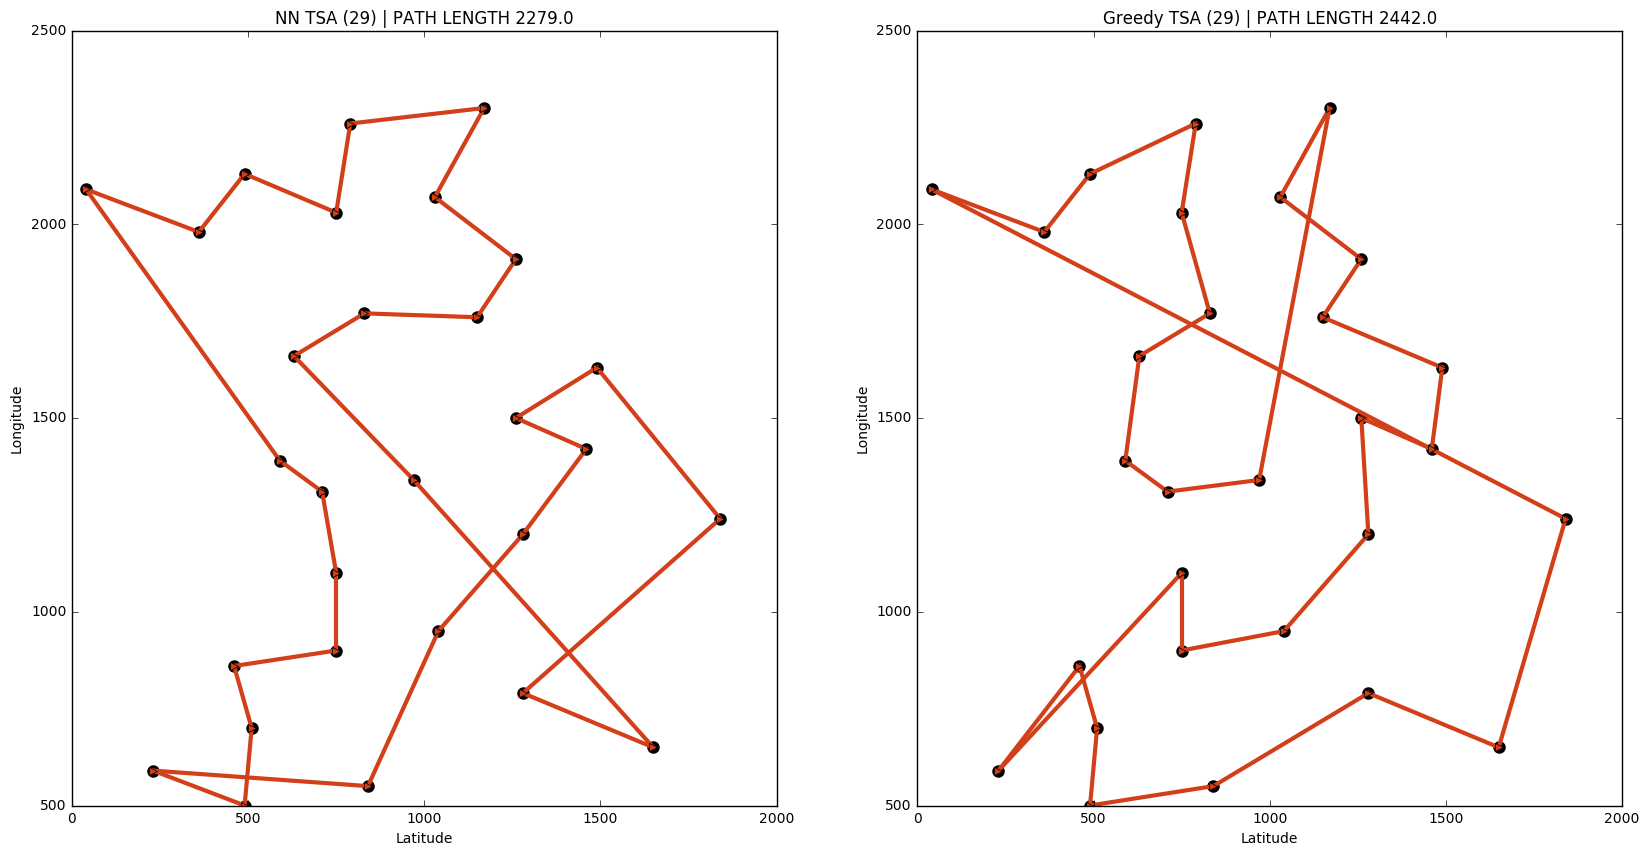

In [23]:
plot_me_please(coordinates29, tour_nn_29, tour_greed_29, "NN TSA (29) | PATH LENGTH " + 
               str(cost_nn_29), "Greedy TSA (29) | PATH LENGTH " + str(cost_greed_29))

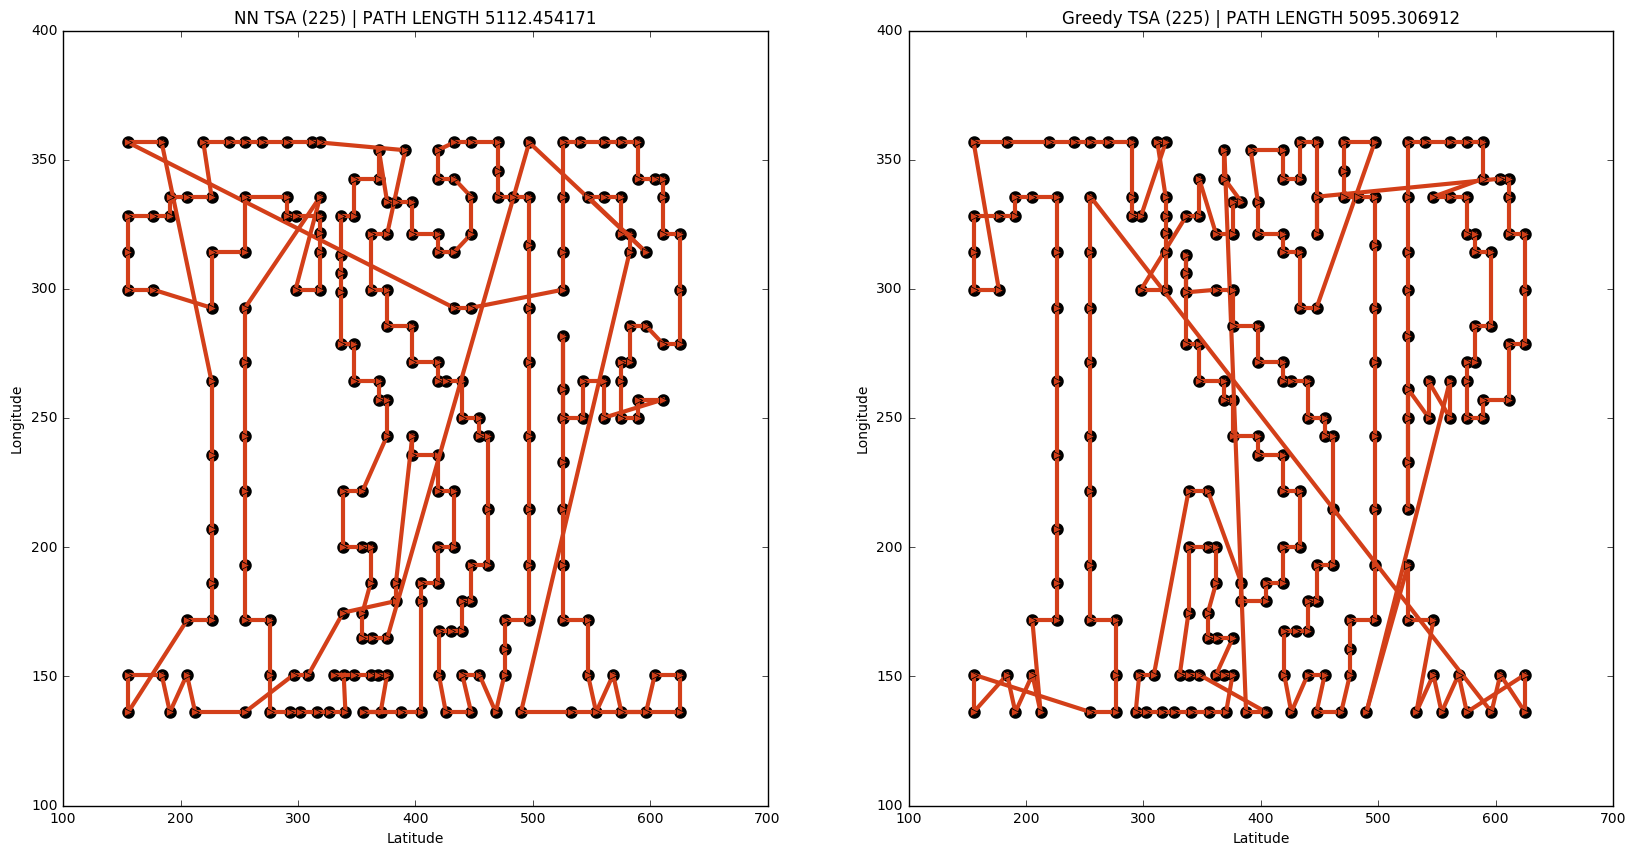

In [24]:
plot_me_please(coordinates225, tour_nn_225, tour_greed_225, "NN TSA (225) | PATH LENGTH " + 
               str(cost_nn_225), "Greedy TSA (225) | PATH LENGTH " + str(cost_greed_225))

* For the '29' dataset, a shorter path is found by the Nearest Neighbour TSA algorithm.
* For the '225' dataset, a shorter path is found by the Greedy TSA algorithm.
* Note that the above highly depends on the starting value in the Nearest Neighbour TSA algorithm and the way of ordering same-length edges in the Greedy TSA algorithm (can be changed with 'shuffle' parameter).
* Seeing if a tour is optimal is non-trivial. Generally, the less jumps (long paths) that are noted, the better. For the last dataset (225), an optimal is problably reached when the letters 'TLP' appear. This could be a 'goldon standard' dataset, which enables the user to distinguish good paths from bad ones by eye.